# Solving Shroedinger bridges via Maximum Likelihood Estimation

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


import torchvision
from torchvision.transforms import ToTensor
 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_swiss_roll
%matplotlib inline

from collections import defaultdict
import math
from tqdm import tqdm

## Dynamic Shroedinger bridge problem

### 1.1 DSBP

We start with Dynamic Shroedinger Bridge Problem (DSBP) between two data distribution $\pi_{0}$ and $\pi_{1}$ correspondingly. One would like to find process $\mathbb{Q}$ that is descrided by the SDE 
$$dx(t) = b(x,t)dt + \sqrt{\gamma}dW(t)$$, which is more closed to the prior process $\mathbb{Q}_{0}^{\gamma}$.

The Wiener process is the prior process $\mathbb{Q}_{0}^{\gamma}$ with $\gamma$ volatility. In other words, $\mathbb{Q}_{0}^{\gamma}$ is the stochastic process that is described by the following stochastic differential equation with initial distribution $\pi_{0}^{\mathbb{Q}_{0}^{\gamma}}$ for the prior process.

$$dx(t) = \sqrt{\gamma}dW(t), \quad x(0) \sim \pi_{0}^{\mathbb{Q}_{0}^{\gamma}}$$

Thus, the DSBP is defined as in KL terms:

$$ \min_{\mathbb{Q} \in \mathcal{D}(\pi_{0},\pi_{1})} \mathbb{D}_{KL}(\mathbb{Q}||\mathbb{Q}_{0}^{\gamma})$$

### 1.2 Stochastic control formulation

The lemma 2 (Pavon and Wakolbinger) from the paper states the following equivalence between DSBP and Stochastic control formulation.

$$ \min_{\mathbb{Q} \in \mathcal{D}(\pi_{0},\pi_{1})} \mathbb{D}_{KL}(\mathbb{Q}||\mathbb{Q}_{0}^{\gamma}) \iff 
    \min_{b \in \mathcal{B}} \int_{0}^{1} \int_{\mathbb{R}^{n}}\frac{1}{2\gamma} \rho(t, x)||b(x,t)||^{2} dx dt $$
    
with the following border conditions
 
$$ dx(t) = b(x,t)dt + \sqrt{\gamma}dW(t) , \quad x(0) \sim \pi_{0} , \quad x(1) \sim \pi_{1}$$

With Euler-Maruyama discretization:

$$x(t) = x(t-1) + b(x(t-1),t-1)dt + \epsilon \sqrt{\gamma} \sqrt{dt} $$

## 1. Data for the Experiment

In [101]:
def make_gaussians_dataset(n_samples, n_gaussians, radius, std):
    
    """Makes n gaussians with centers on a circle of given radius"""
    
    angle_between_gaussians = 2*np.pi/n_gaussians
    centers = radius*np.array([
        [np.cos(i*angle_between_gaussians), np.sin(i*angle_between_gaussians)] for i in range(n_gaussians)
        ]
    )

    data = make_blobs(n_samples, n_features=2, centers=centers, cluster_std=std)[0]

    return TensorDataset(torch.tensor(data).float())

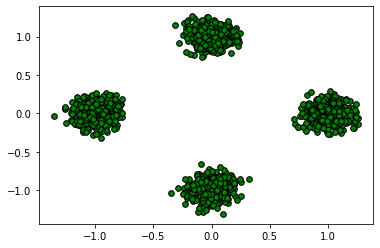

In [102]:
input_dataset = make_gaussians_dataset(n_samples = 2000, n_gaussians=4, radius=1, std=0.1)
plt.scatter(input_dataset.tensors[0].numpy()[:, 0], input_dataset.tensors[0].numpy()[:, 1],
        c="g", s=32, edgecolors="black");

In [103]:
def make_swiss_roll_dataset(n_samples, scale=0.2, std=1):
    data = scale*make_swiss_roll(n_samples=n_samples, noise=std)[0][:, [0, 2]]
    
    return TensorDataset(torch.tensor(data).float())

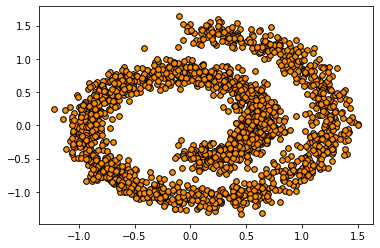

In [104]:
output_dataset =  make_swiss_roll_dataset(n_samples = 2000, scale=0.1, std=1)
plt.scatter(output_dataset.tensors[0].numpy()[:, 0], output_dataset.tensors[0].numpy()[:, 1],
        c="darkorange", s=32, edgecolors="black");

In [105]:
class DataLoaderSampler():
    
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.iterator = iter(data_loader)
        
    def sample(self):
        sample = next(self.iterator, None)
        if sample is None:
            self.iterator = iter(self.data_loader)
            sample = next(self.iterator, None)
            
        return sample[0]

## 2. Net architecture and its training

In [108]:
def get_trained_net(Xs, Ys, net, dim = 2, device="cpu", num_epochs=50, batch_size=64):
    
    """
    
    Xs - torch.Size([B, N + 1])
    Ys - torch.Size([B, N])
    
    """
    with torch.no_grad():
        # I *think* it's legitimate to put this all in a no_grad()...
        num_samples = Xs.size(0)
        Xs = Xs[:, :-1]
        assert Ys.size(0) == num_samples
        
        xs_reshaped = Xs.reshape(num_samples, dim)
        ys_reshaped = Ys.reshape(num_samples, dim)
        
 
        criterion = nn.MSELoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        if batch_size is None:
            batch_size = xs_reshaped.size(0)
        ds = TensorDataset(xs_reshaped, ys_reshaped)
        dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    
    losses = []
    for epoch in range(num_epochs): 
        for i, data in enumerate(dl):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
#         losses.append(loss.item())
#     plt.plot(list(range(len(losses))), losses)
#     plt.show()
    return lambda x: net(x[:, :-1]).reshape(-1,dim)

## 3. Stochastic Differential Equation

In [82]:
def solve_sde_RK(b_drift, sigma, X0=None, dt=1.0, N=100, t0=0.0,
                 theta=None, noise=False, forwards=True, device='cpu'):
   
    """ Euler Mayurama method
    Syntax:
    ----------
    solve_sde(b_drift=None, sigma=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        b_drift: Time depdendent drift, the X state (with last dimension as 
                 time) defines the differential equation.
        sigma  : a  constant volatility
        X0     : Initial conditions of the SDE. Mandatory for SDEs
                 with variables > 1 (default: gaussian np.random)
        dt     : The timestep of the solution
                 (default: 1)
        N      : The number of timesteps (defines the length of the timeseries)
                 (default: 100)
        t0     : The initial time of the solution
                 (default: 0)
    """
    
    N = int(N) + 1
    
    n, d, *_ = X0.shape

    T = torch.tensor(dt * N).to(device)
    DWs = torch.empty((n, N - 1, d)).normal_(mean=0, std=1).to(device) * math.sqrt(dt)

    Y = torch.zeros((n, N, d + 1)).to(device)
    ti = torch.arange(N).to(device) * dt + t0

    t0rep = (t0 * torch.ones((X0.shape[0], 1)).to(device) if forwards
             else (T - t0) * torch.ones((X0.shape[0], 1)).to(device))

     
    sigmas = torch.full((N,), math.sqrt(sigma)).to(device)
  
    Y = torch.cat((X0.to(device), t0rep), axis=1)[:, None, :]
    T = dt * N
    
    for n in range(N - 1):
        t = ti[n + 1]
        b, DW_n = b_drift(Y[:, n, :]), DWs[:, n, :]
        newY = Y[:, n, :-1] + b * dt + sigmas[n + 1] * DW_n

        trep = (t.repeat(newY.shape[0]).reshape(-1, 1) if forwards
                else T - t.repeat(newY.shape[0]).reshape(-1, 1))
        # print(trep)
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y, tocat), dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
    return ti, Y

In [24]:
def prior_drift(x, device = "cpu"):
    return torch.tensor([0] * (x.shape[1] - 1)).reshape((1, -1)).repeat(x.shape[0], 1).to(device)

In [16]:
def drift_net(hiddens):
    
    model = []
    for inp, out in zip(hiddens[:-1],hiddens[1:]):
        model.append(torch.nn.Linear(inp, out, bias = True))
        model.append(torch.nn.ReLU())
    model.pop()
    
    return torch.nn.Sequential(*model)

## 4. Drift - Fit

In [107]:
def fit_drift(Xts,net,dt):
    
    """
    
    Xts - torch.Size([B,N+1,d+1])
    
    
    """
    
 
    X_0 = Xts[:, 0, 0].reshape(-1, 1) #?
    
    Ys = ((Xts[:, 1:, :-1] - Xts[:, :-1, :-1]) / 
          (dt)).reshape((-1, Xts.shape[2] - 1))
    
    # Drop the last timepoint in each timeseries
    Xs = Xts[:, :-1, :].reshape((-1, Xts.shape[2])) 
    
    return get_trained_net(Xs, Ys, net, device='cpu', num_epochs= NUM_EPOCHS_UNET, 
                                batch_size=100)

## 5. MLE-IPFP algorithm

In [113]:
def MLE_IPFP(X_0, X_1, N, sigma, net, num_iterations, device = "cpu"):
    
    """
    
    X_0       - torch.Size([B,dim]) \sim \pi_0
    X_1       - torch.Size([B,dim]) \sim \pi_1
    N_steps   - int , num steps of diffusion 
    sigma     - int , variance of diffusion process (\gamma)
    
    """
    dt = 1.0 / N 
    prior_X_0 = X_0 # torch.Size([B,dim])
    
    drift_forward = None
    drift_backward = None
    
    t, Xts = solve_sde_RK(b_drift=prior_drift, sigma=sigma, X0=prior_X_0, dt=dt, 
                          N=N, device=device)
    
    # t, Xts - torch.size([N + 1]),torch.Size([B,N + 1,dim+1])
    
    Xts[:, :, :-1] = Xts[:, :, :-1].flip(1)
    
    drift_backward = fit_drift(Xts, net, dt=dt)
    
    
    for i in tqdm(range(num_iterations)):
         
            
        t, Xts = solve_sde_RK(b_drift=drift_backward, sigma=sigma, X0=X_1, 
                              dt=dt, N=N, device=device)
        
        del drift_forward
        
     
      
        Xts[:, :, :-1] = Xts[:, :, :-1].flip(1)
 

        del drift_backward

        drift_forward = fit_drift(
            Xts, net, dt=dt
        )
       

        # Estimate backward drift
        # Start from X_0 and roll until t=1 using drift_forward
        # HERE: HERE is where the GP prior kicks in and helps the most
        t, Xts = solve_sde_RK(b_drift=drift_forward, sigma=sigma, X0=X_0, dt=dt,
                              N=N, device=device)
        

        # Reverse the series
        Xts[:, :, :-1] = Xts[:, :, :-1].flip(1)

        drift_backward = fit_drift(
            Xts, net, dt=dt)
            # One wouuld think this should (worth rethinking this)
            # be prior drift backwards here
            # but that doesnt work as well,
            # Its kinda clear (intuitively)
            # that prior_drift backwards
            # as a fallback is not going to help
            # this prior, instead the prior of this GP
            # should be inherting the backwards drift
            # of the GP at iteration 1 sadly we dont 
            # have such an estimate thus this should be None
            
    return drift_forward, drift_backward
    

## 6. Training

In [156]:
# hyper parameters
DIM = 2
DEVICE = "cpu"
NUM_EPOCHS_NET = 50
BATCH_SIZE_NET = 64
HIDDENS = [DIM,64,128,64,DIM]
BATCH_SIZE = 256
N_STEPS = 100
NUM_ITERATIONS = 50

NUM_COMPONENTS = 4
STD = 0.1
RADIUS = 1
DATASET_NUM_SAMPLES = 2**10
SCALE_SWISS = 0.2
STD_SWISS = 0.1
SIGMA = 10

# data
input_dataset = make_gaussians_dataset(DATASET_NUM_SAMPLES, n_gaussians= NUM_COMPONENTS, radius= RADIUS, std = STD)
output_dataset = make_swiss_roll_dataset(DATASET_NUM_SAMPLES, scale = SCALE_SWISS, std = STD_SWISS)
input_distr_sampler = DataLoaderSampler(DataLoader(input_dataset, BATCH_SIZE))
output_distr_sampler = DataLoaderSampler(DataLoader(output_dataset, BATCH_SIZE))

net = drift_net(HIDDENS)
forward, backward = MLE_IPFP(input_distr_sampler.sample(), output_distr_sampler.sample() , N_STEPS,SIGMA, net, device = "cpu", 
         num_iterations= NUM_ITERATIONS)

100%|██████████| 50/50 [54:04<00:00, 64.89s/it]


In [198]:
def plot_results(original_dataset, target_dataset, transfered_dataset):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].scatter(
        original_dataset.numpy()[:, 0], original_dataset.numpy()[:, 1],
        c="g", s=32, edgecolors="black"
    )
    axes[0].set_title("Input distribution")

    axes[1].scatter(
        target_dataset.numpy()[:, 0], target_dataset.numpy()[:, 1],
        c="orange", s=32, edgecolors="black"
    )
    axes[1].set_title("Target distribution")

    axes[2].scatter(
        transfered_dataset.numpy()[:, 0], transfered_dataset.numpy()[:, 1],
        c="yellow", s=32, edgecolors="black"
    )
    axes[2].set_title("Fitted distribution")
    
    
    
    plt.plot()

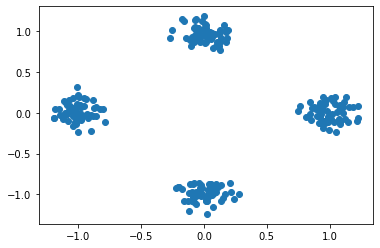

In [206]:
x = input_distr_sampler.sample()
plt.scatter(x[:,0],x[:,1])

In [164]:
t = torch.rand(x.shape[0])
y = torch.cat([x,t[:,None]],dim=1)
z = forward(y)

In [186]:
p.shape

torch.Size([256, 2])

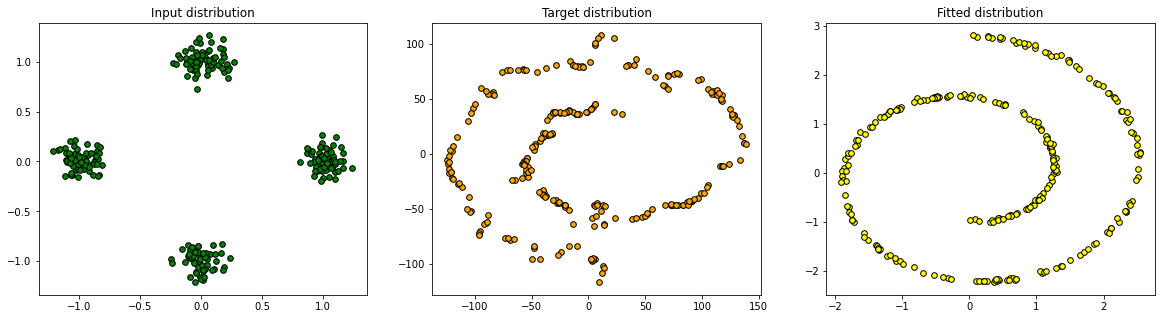

In [200]:
plot_results(x,z.detach().cpu(),p)

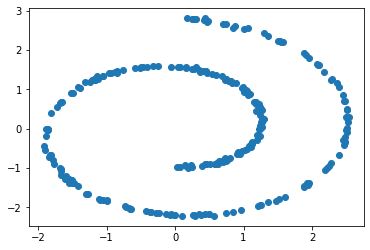

In [210]:
x = output_distr_sampler.sample()
plt.scatter(x[:,0],x[:,1])

In [212]:
t = torch.rand(x.shape[0])
y = torch.cat([x,t[:,None]],dim=1)
z = backward(y)

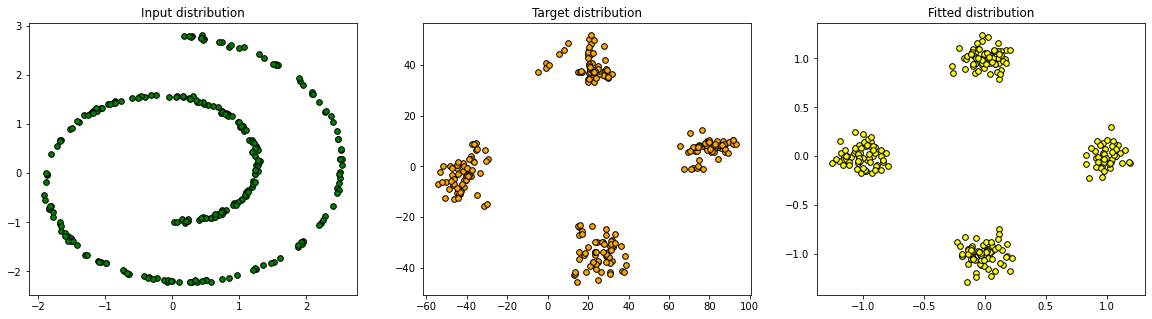

In [211]:
plot_results(x,z.detach().cpu(),p)